# Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

ModuleNotFoundError: No module named 'keras'

## Data Cleaning and Visualization of Badminton Data

This notebook demonstrates the process of cleaning and visualizing badminton data using Python and pandas. The dataset consists of two CSV files: `badmintondata.csv` and `badmintondata2.csv`. The goal is to combine the datasets, clean the data, and generate a 3D scatterplot for visualization.

### Data Loading and Cleaning

- The first step is to load the data from the CSV files using pandas' `read_csv` function.
- Missing values are handled by dropping rows with missing values using the `dropna` method.
- Outliers are identified and removed using the z-score method. Rows with z-scores exceeding a certain threshold are considered outliers and filtered out.
- Inconsistencies in the data, such as decimal separators, are addressed by replacing commas with periods and converting the data to float format.

### Data Combination

- The two datasets, `badmintondata.csv` and `badmintondata2.csv`, are combined into a single dataframe using pandas' `concat` function.

### Data Visualization

- A 3D scatterplot is generated to visualize the badminton data.
- Two scatterplots are shown side by side:
  - Cleaned Combined Dataset: The dataset after cleaning, with outliers removed and inconsistencies addressed.
  - Uncleaned Combined Dataset: The dataset before cleaning, with outliers and inconsistencies present.
- The scatterplots provide insights into the distribution and patterns of the data in three-dimensional space.


Number of rows before cleaning: 315200
Number of rows after cleaning: 168842


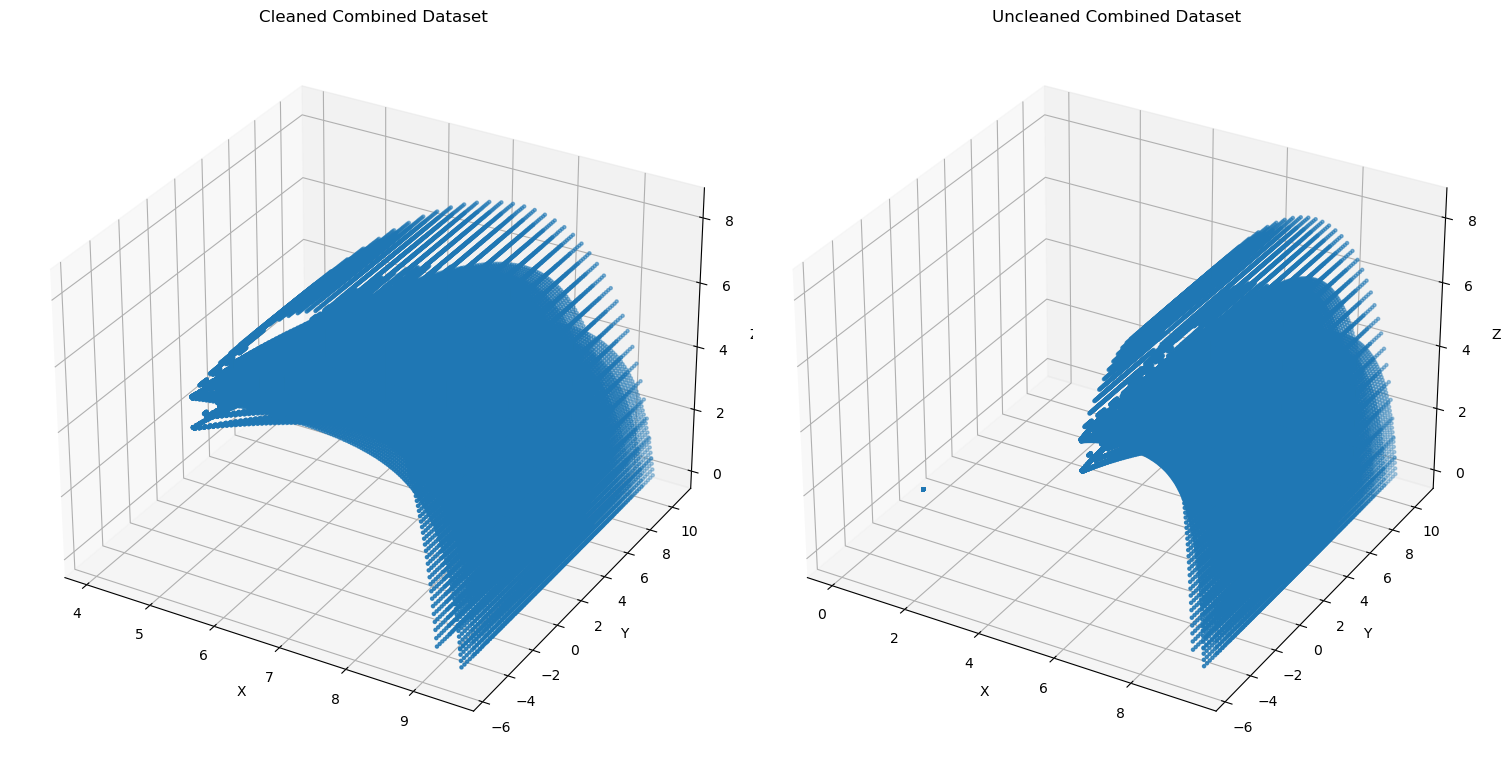

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the first dataset
df1 = pd.read_csv('badmintondata.csv')

# Load the second dataset
df2 = pd.read_csv('badmintondata2.csv')

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Count rows before cleaning
rows_before_cleaning = df_combined.shape[0]

# Handling missing values
df_combined = df_combined.dropna()  # Drop rows with missing values

# Handling outliers (Using z-score)
z_scores_combined = (df_combined - df_combined.mean()) / df_combined.std()  # Calculate z-scores
threshold = 3  # Set a threshold for outliers
outliers_combined = (z_scores_combined.abs() > threshold).any(axis=1)  # Find rows with outliers
df_combined_cleaned = df_combined[~outliers_combined].copy()  # Filter out rows with outliers

# Identify consecutive rows of all zeros
mask = (df_combined == 0).all(axis=1)
groups = mask.cumsum()

# Filter out consecutive rows of all zeros
df_combined_cleaned = df_combined[~mask]
df_combined_cleaned.to_csv('cleaned_dataset.csv', index = False)

# Count rows after cleaning
rows_after_cleaning = df_combined_cleaned.shape[0]

print("Number of rows before cleaning:", rows_before_cleaning)
print("Number of rows after cleaning:", rows_after_cleaning)

# Generate scatterplot for the cleaned combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Cleaned Combined Dataset
axes[0].scatter(df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title('Cleaned Combined Dataset')
axes[0].grid(True)

# Uncleaned Combined Dataset
axes[1].scatter(df_combined['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title('Uncleaned Combined Dataset')
axes[1].grid(True)

plt.tight_layout()
plt.show()


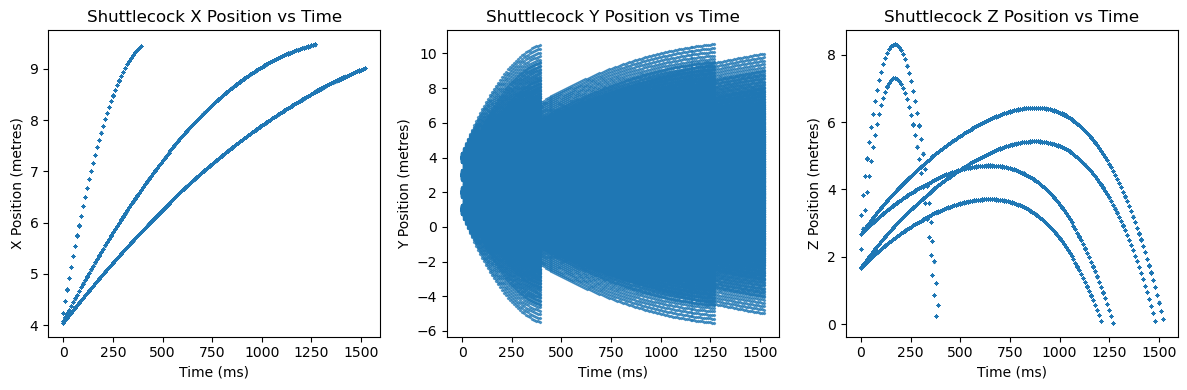

In [4]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups, group_keys=False)

# Function to add a Time field to a group
def add_time_field(group):
    group['TIME'] = np.arange(len(group)) * 10  # Multiply by 10 to get time in ms
    return group

grouped_df = grouped_df.apply(add_time_field)

# Create subplots with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the X position vs Time
axs[0].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(X) metres'], marker='x', s=2, alpha=0.8)
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('X Position (metres)')
axs[0].set_title('Shuttlecock X Position vs Time')

# Plot the Y position vs Time
axs[1].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Y) metres'], marker='x', s=2, alpha=0.8)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Y Position (metres)')
axs[1].set_title('Shuttlecock Y Position vs Time')

# Plot the Z position vs Time
axs[2].scatter(grouped_df['TIME'], grouped_df['SHUTTLECOCK POSITIION IN AIR(Z) metres'], marker='x', s=2, alpha=0.8)
axs[2].set_xlabel('Time (ms)')
axs[2].set_ylabel('Z Position (metres)')
axs[2].set_title('Shuttlecock Z Position vs Time')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


In [5]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups)

# Split the groups into testing set and sample set (split into a testing set and a sample set using a 70:30 ratio)
train_groups, test_groups = train_test_split(list(grouped_df.groups), test_size=0.3, random_state=42)

# Create the training set
train_df = pd.concat([grouped_df.get_group(group) for group in train_groups])

# Create the testing set
test_df = pd.concat([grouped_df.get_group(group) for group in test_groups])

# Apply a TIME-based transformation to each group in the train and test data
train_df = train_df.groupby(groups, group_keys=False).apply(add_time_field)
test_df = test_df.groupby(groups, group_keys=False).apply(add_time_field)

In [6]:
# Define the non-feature columns
non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME"]

# Define the feature columns
feature_cols = ["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres",
                "SHUTTLECOCK POSITIION IN AIR(Z) metres"]

# Create the training feature DataFrame
train_features = train_df[feature_cols].copy()

# Create the training non-feature DataFrame
train_non_features = train_df[non_feature_cols].copy()

# Create the testing feature DataFrame
test_features = test_df[feature_cols].copy()

# Create the testing non-feature DataFrame
test_non_features = test_df[non_feature_cols].copy()

# Display the training feature DataFrame
print("Training Features:")
print(train_features.head())

# Display the training non-feature DataFrame
print("\nTraining Non-Features:")
print(train_non_features.head())

# Display the testing feature DataFrame
print("\nTesting Features:")
print(test_features.head())

# Display the testing non-feature DataFrame
print("\nTesting Non-Features:")
print(test_non_features.head())


Training Features:
        SHUTTLECOCK POSITIION IN AIR(X) metres  \
155400                                4.049012   
155401                                4.099699   
155402                                4.148521   
155403                                4.198738   
155404                                4.246939   

        SHUTTLECOCK POSITIION IN AIR(Y) metres  \
155400                                0.957395   
155401                                0.913333   
155402                                0.870893   
155403                                0.827240   
155404                                0.785339   

        SHUTTLECOCK POSITIION IN AIR(Z) metres  
155400                                2.685690  
155401                                2.770077  
155402                                2.854290  
155403                                2.934386  
155404                                3.012884  

Training Non-Features:
        HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITI

In [6]:
main_non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "TIME", "SHUTTLECOCK POSITIION IN AIR(Z) metres" ]

time_non_feature_cols = ["HUMAN PLAYER POSITION (X) metres", "HUMAN PLAYER POSITION (Y) metres",
                    "INITITAL VELOCITY OF SHUTTELCOCK(m/s)", "INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)",
                    "SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)", "SHUTTLECOCK POSITIION IN AIR(Z) metres" ]

def getModelString(name, coefficients ,intercept) :
    # This model is for x and y only , cause they will have a fixed z value they wanna predict from
    modelStr = ''
    for index,(feature, coef) in enumerate(zip(main_non_feature_cols, coefficients)):
        modelStr += str(coef)+" X"+ str(index+1) + " + "
    
    return name+" : "+modelStr + str(intercept)

X_train = train_df[main_non_feature_cols].copy()
y_train = train_df["SHUTTLECOCK POSITIION IN AIR(X) metres"].copy()

X_test = test_df[main_non_feature_cols].copy()
y_test = test_df["SHUTTLECOCK POSITIION IN AIR(X) metres"].copy()

# Step 4: Preprocess numerical features (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming a binary classification problem

# Step 6: Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 7: Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


NameError: name 'StandardScaler' is not defined

Z (height) predictor:
  RMSE: 0.3769561647162039
  MAE: 0.30758023290756226
  Explained Variance Score: 0.9484788397737008
  Maximum Error: 0.9438912799921413
X (side) predictor:
  RMSE: 283.1303957237873
  MAE: 167.92041434760856
  Explained Variance Score: -21717.016282510638
  Maximum Error: 974.7622033279216
Y (forward) predictor:
  RMSE: 163395.69959947222
  MAE: 97073.81343070087
  Explained Variance Score: -3394241511.9986196
  Maximum Error: 563522.315161583


NameError: name 'predicted_height' is not defined

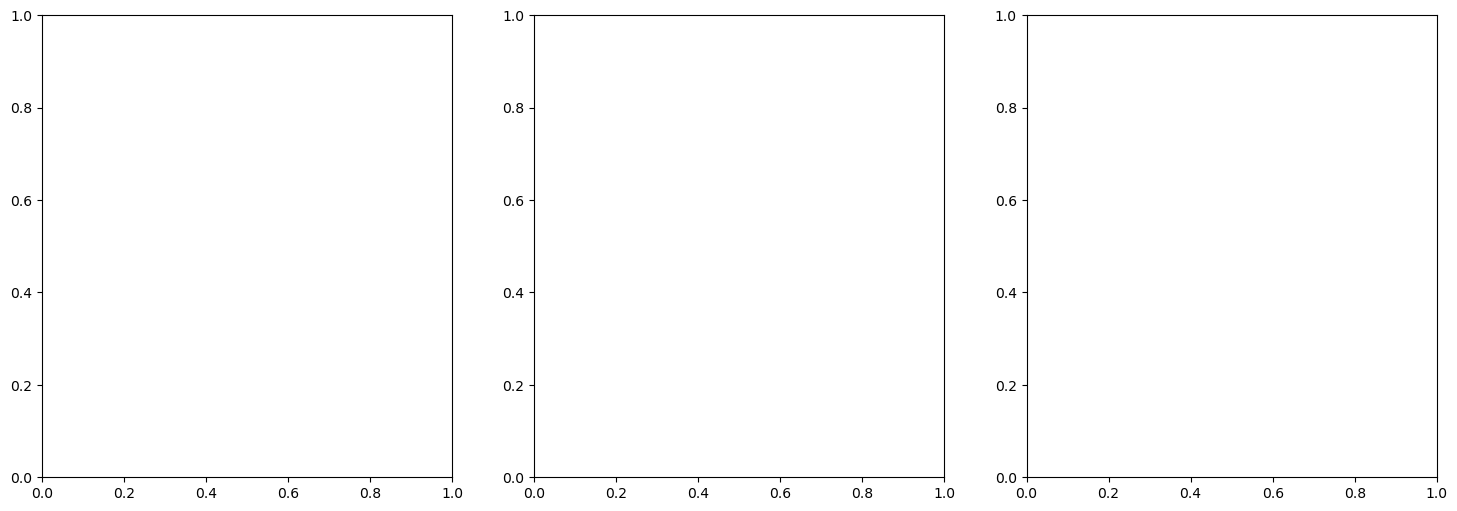

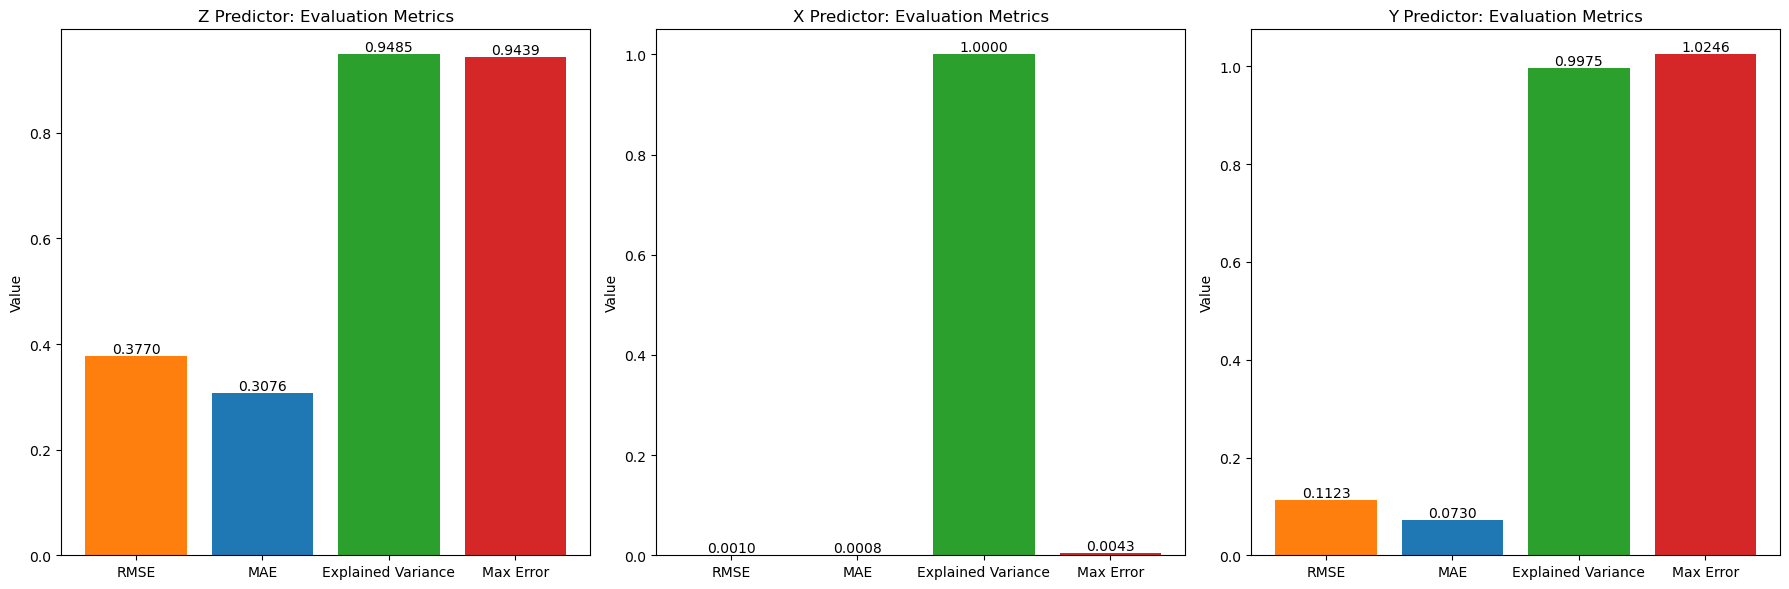

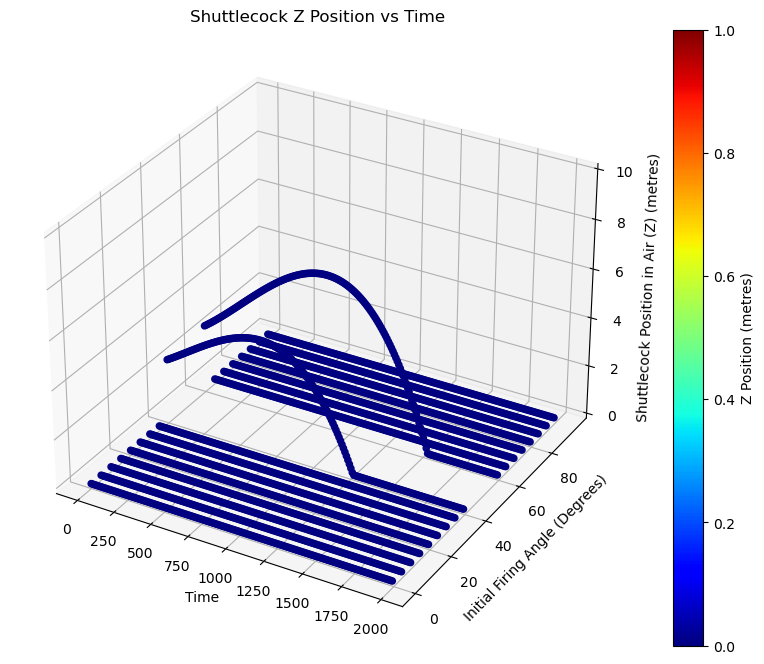

Robot Initial Position: [107.0559704  168.5002738  177.59893145]
Estimated Position: [-29.7631716    1.23699823 134.39071833]
Robot Final Position: [-29.7631716    1.23699823 134.39071833]
Movement Time (sec): 0.7345704009401195

Robot Initial Position: [163.74365282 150.35868699 103.46190329]
Estimated Position: [-29.53149683   1.30864769 134.93679218]
Robot Final Position: [-29.53149683   1.30864769 134.93679218]
Movement Time (sec): 0.8203106885525393

Robot Initial Position: [208.1642431   61.32026307  65.81380172]
Estimated Position: [-29.30498175   1.37997501 135.45051518]
Robot Final Position: [-29.30498175   1.37997501 135.45051518]
Movement Time (sec): 0.8487490320482527

[107.0559704  168.5002738  177.59893145]
The prediction accuracy is within 1 cm deviation

Height Error (cm): 0.30758023290756226
Side Error (cm): 0.0007955887028944308
Forward Error (cm): 0.07297452875726858


### Predicting X and Y to a fix value of Z (0.8323 meter) as optimal height

In [65]:
import numpy as np

dummyData = """
4	1	10	40	0	4.075542591	1	1.662911962
4	1	10	40	0	4.152006773	1	1.72486637
4	1	10	40	0	4.228906143	1	1.788139098
4	1	10	40	0	4.302099746	1	1.845244983
4	1	10	40	0	4.376877391	1	1.904127726
4	1	10	40	0	4.449410593	1	1.962541187
4	1	10	40	0	4.522097914	1	2.018857335
4	1	10	40	0	4.595428732	1	2.071654009
4	1	10	40	0	4.668033747	1	2.127861644
4	1	10	40	0	4.739584146	1	2.178635753
4	1	10	40	0	4.809587653	1	2.233492954
4	1	10	40	0	4.881531438	1	2.28340222
4	1	10	40	0	4.95120765	1	2.332455057
4	1	10	40	0	5.021340663	1	2.379732739
4	1	10	40	0	5.089209194	1	2.430622608
4	1	10	40	0	5.158574787	1	2.475123289
4	1	10	40	0	5.226182675	1	2.522975118
4	1	10	40	0	5.294275267	1	2.565753026
4	1	10	40	0	5.359640471	1	2.608968419
4	1	10	40	0	5.425936189	1	2.653999671
4	1	10	40	0	5.491976752	1	2.694693412
4	1	10	40	0	5.555443927	1	2.736440902
4	1	10	40	0	5.619701891	1	2.777969097
4	1	10	40	0	5.686355961	1	2.816387675
4	1	10	40	0	5.750565811	1	2.856549264
4	1	10	40	0	5.813225022	1	2.894873788
4	1	10	40	0	5.87702102	1	2.931634222
4	1	10	40	0	5.93744245	1	2.967813503
4	1	10	40	0	5.998026029	1	3.00229617
4	1	10	40	0	6.06018676	1	3.037646513
4	1	10	40	0	6.119851235	1	3.071123013
4	1	10	40	0	6.179717661	1	3.104296564
4	1	10	40	0	6.239443316	1	3.136480762
4	1	10	40	0	6.298751278	1	3.170356064
4	1	10	40	0	6.35754129	1	3.200093494
4	1	10	40	0	6.415799555	1	3.228748951
4	1	10	40	0	6.474238157	1	3.258815171
4	1	10	40	0	6.530246569	1	3.288896296
4	1	10	40	0	6.584370532	1	3.315348236
4	1	10	40	0	6.641468727	1	3.342570654
4	1	10	40	0	6.697290025	1	3.369862986
4	1	10	40	0	6.751135684	1	3.392916604
4	1	10	40	0	6.803924231	1	3.418027204
4	1	10	40	0	6.858154359	1	3.442182052
4	1	10	40	0	6.911022954	1	3.462081522
4	1	10	40	0	6.965863746	1	3.486002737
4	1	10	40	0	7.017793031	1	3.504532151
4	1	10	40	0	7.06912573	1	3.524526313
4	1	10	40	0	7.118604365	1	3.543596794
4	1	10	40	0	7.16998568	1	3.564259625
4	1	10	40	0	7.220082278	1	3.580330713
4	1	10	40	0	7.268251588	1	3.596466385
4	1	10	40	0	7.318120937	1	3.612633423
4	1	10	40	0	7.367571356	1	3.624884021
4	1	10	40	0	7.414373328	1	3.637442719
4	1	10	40	0	7.462860659	1	3.651028645
4	1	10	40	0	7.508528734	1	3.66281677
4	1	10	40	0	7.55456399	1	3.670795919
4	1	10	40	0	7.600386555	1	3.680116652
4	1	10	40	0	7.645639739	1	3.689246186
4	1	10	40	0	7.689013866	1	3.695125529
4	1	10	40	0	7.733527074	1	3.698971408
4	1	10	40	0	7.776838472	1	3.704279934
4	1	10	40	0	7.82095767	1	3.707068057
"""

rows = dummyData.strip().split('\n')
arr = pd.DataFrame(np.array([row.split('\t') for row in rows], dtype=float))

# # We know the 7th array is the z value hence
# differences = np.diff(arr[7])

# # Calculate the average difference
# average_difference = np.mean(np.abs(differences))

# # Estimited time at Z = 0.8323 with the travel speed of 10ms per capture
# estimitedTimeAtZ = (len(arr)+np.floor((np.max(arr[7])-0.8323)/average_difference))*10

# # As we know that the first 5 column is the same we will shown with a fix value of y as shown , we pick the first arr which is [0] 
# # We also want to find the fix z value at 0.8323 hence is inside there
# print(np.floor((np.max(arr[7])-0.8323)/average_difference))
trueData = np.array([[arr[0][0],arr[0][1],arr[0][2],arr[0][3],arr[0][4],1150, 0.8323 ]])

# transformData = poly.transform(trueData)
# [0] because is will only be one dimension as we only put in one dimension
predictedXValue = reg_side.predict(trueData)[0]
predictedYValue = reg_forward.predict(trueData)[0]
print("It is predicted that the shuttercork will be falling at the coordinate ( " ,predictedXValue," , ",predictedYValue," ) when Z is 0.8323 meter")


It is predicted that the shuttercork will be falling at the coordinate (  10.828798804208843  ,  4.530017070901469  ) when Z is 0.8323 meter


c:\Users\dougl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\dougl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
